<a href="https://colab.research.google.com/github/aymenchibouti/newversion/blob/master/tuning_XAI_RES.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install shap lime xgboost imbalanced-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 6.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=e94cf6800eab77e59454f0d14e9b1729f9e095630d2d92b81c3b4d7d78c414e9
  Stored in directory: /root/.cache/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime


In [2]:
# Install required packages
!pip install shap lime xgboost imbalanced-learn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV, validation_curve
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.metrics import roc_curve, auc, precision_recall_curve
import shap
import lime
import lime.lime_tabular
import xgboost as xgb
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings('ignore')

# Set style for better plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

def load_and_preprocess_data(file_path):
    """Load and preprocess the dataset"""
    print("Loading dataset...")
    data = pd.read_csv(file_path)
    print(f"Dataset shape: {data.shape}")

    # Drop non-numeric columns that are not useful for prediction
    columns_to_drop = ['username', 'course_id', 'enrollment_id']
    existing_cols_to_drop = [col for col in columns_to_drop if col in data.columns]
    data = data.drop(columns=existing_cols_to_drop)

    # Handle missing values
    data.fillna(0, inplace=True)

    # Separate features and target variable
    X = data.drop(columns=['dropout'])
    y = data['dropout']

    print(f"Features shape: {X.shape}")
    print(f"Target distribution: {y.value_counts()}")

    return X, y, data

def create_balanced_dataset(X, y):
    """Create balanced dataset using SMOTE"""
    print("Applying SMOTE for class balancing...")

    # Standardize features first
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Apply SMOTE
    smote = SMOTE(sampling_strategy='auto', random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X_scaled, y)

    print(f"Original dataset shape: {X.shape}")
    print(f"Resampled dataset shape: {X_resampled.shape}")
    print(f"New target distribution: {pd.Series(y_resampled).value_counts()}")

    return X_resampled, y_resampled, scaler

def train_models(X_train, X_test, y_train, y_test):
    """Train and tune all models"""
    print("Training models...")

    # 1. Logistic Regression
    print("Training Logistic Regression...")
    lr = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
    lr.fit(X_train, y_train)

    # 2. Random Forest with RandomizedSearchCV
    print("Training Random Forest with hyperparameter tuning...")
    param_dist_rf = {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'bootstrap': [True, False]
    }

    rf = RandomForestClassifier(random_state=42)
    rf_random_search = RandomizedSearchCV(estimator=rf, param_distributions=param_dist_rf,
                                        n_iter=50, cv=3, random_state=42, n_jobs=-1)
    rf_random_search.fit(X_train, y_train)
    best_rf = rf_random_search.best_estimator_

    # 3. XGBoost with RandomizedSearchCV
    print("Training XGBoost with hyperparameter tuning...")
    param_dist_xgb = {
        'max_depth': [3, 6, 9],
        'learning_rate': [0.01, 0.1, 0.3],
        'n_estimators': [50, 100, 150],
        'subsample': [0.8, 0.9, 1.0],
        'colsample_bytree': [0.8, 0.9, 1.0]
    }

    xgb_model = xgb.XGBClassifier(random_state=42)
    xgb_random_search = RandomizedSearchCV(estimator=xgb_model, param_distributions=param_dist_xgb,
                                         n_iter=50, cv=3, random_state=42, n_jobs=-1)
    xgb_random_search.fit(X_train, y_train)
    best_xgb = xgb_random_search.best_estimator_

    models = {
        'Logistic Regression': lr,
        'Random Forest': best_rf,
        'XGBoost': best_xgb
    }

    print("Model training completed!")
    return models

def evaluate_models(models, X_test, y_test):
    """Evaluate all models and return metrics"""
    results = {}

    for name, model in models.items():
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else None

        results[name] = {
            'accuracy': accuracy_score(y_test, y_pred),
            'precision': precision_score(y_test, y_pred),
            'recall': recall_score(y_test, y_pred),
            'f1': f1_score(y_test, y_pred),
            'predictions': y_pred,
            'probabilities': y_pred_proba
        }

    return results

def plot_model_comparison(results):
    """Create comprehensive model comparison plots"""
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))

    # Metrics comparison
    metrics = ['accuracy', 'precision', 'recall', 'f1']
    models = list(results.keys())

    # Bar plot for metrics comparison
    x = np.arange(len(models))
    width = 0.2

    for i, metric in enumerate(metrics):
        values = [results[model][metric] for model in models]
        axes[0, 0].bar(x + i*width, values, width, label=metric.title(), alpha=0.8)

    axes[0, 0].set_xlabel('Models')
    axes[0, 0].set_ylabel('Score')
    axes[0, 0].set_title('Model Performance Comparison')
    axes[0, 0].set_xticks(x + width * 1.5)
    axes[0, 0].set_xticklabels(models, rotation=45)
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

    # ROC curves
    for name, result in results.items():
        if result['probabilities'] is not None:
            fpr, tpr, _ = roc_curve(y_test, result['probabilities'])
            roc_auc = auc(fpr, tpr)
            axes[0, 1].plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.3f})', linewidth=2)

    axes[0, 1].plot([0, 1], [0, 1], 'k--', alpha=0.5)
    axes[0, 1].set_xlabel('False Positive Rate')
    axes[0, 1].set_ylabel('True Positive Rate')
    axes[0, 1].set_title('ROC Curves')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)

    # Precision-Recall curves
    for name, result in results.items():
        if result['probabilities'] is not None:
            precision, recall, _ = precision_recall_curve(y_test, result['probabilities'])
            pr_auc = auc(recall, precision)
            axes[1, 0].plot(recall, precision, label=f'{name} (AUC = {pr_auc:.3f})', linewidth=2)

    axes[1, 0].set_xlabel('Recall')
    axes[1, 0].set_ylabel('Precision')
    axes[1, 0].set_title('Precision-Recall Curves')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)

    # Confusion matrices (for best model - highest F1)
    best_model = max(results.keys(), key=lambda x: results[x]['f1'])
    cm = confusion_matrix(y_test, results[best_model]['predictions'])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[1, 1])
    axes[1, 1].set_title(f'Confusion Matrix - {best_model}')
    axes[1, 1].set_xlabel('Predicted')
    axes[1, 1].set_ylabel('Actual')

    plt.tight_layout()
    plt.show()

    # Print detailed results
    print("=" * 60)
    print("DETAILED MODEL EVALUATION RESULTS")
    print("=" * 60)

    for name, result in results.items():
        print(f"\n{name}:")
        print(f"  Accuracy:  {result['accuracy']:.4f}")
        print(f"  Precision: {result['precision']:.4f}")
        print(f"  Recall:    {result['recall']:.4f}")
        print(f"  F1 Score:  {result['f1']:.4f}")

def plot_overfitting_analysis(models, X_train, y_train, feature_names):
    """Analyze and visualize overfitting for tree-based models"""
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))

    # Random Forest validation curve
    if 'Random Forest' in models:
        print("Analyzing Random Forest overfitting...")
        param_range = [10, 50, 100, 200, 300, 500]
        train_scores, val_scores = validation_curve(
            RandomForestClassifier(random_state=42), X_train, y_train,
            param_name='n_estimators', param_range=param_range,
            cv=3, scoring='f1', n_jobs=-1
        )

        train_mean = np.mean(train_scores, axis=1)
        train_std = np.std(train_scores, axis=1)
        val_mean = np.mean(val_scores, axis=1)
        val_std = np.std(val_scores, axis=1)

        axes[0].plot(param_range, train_mean, 'o-', color='blue', label='Training score')
        axes[0].fill_between(param_range, train_mean - train_std, train_mean + train_std, alpha=0.1, color='blue')
        axes[0].plot(param_range, val_mean, 'o-', color='red', label='Cross-validation score')
        axes[0].fill_between(param_range, val_mean - val_std, val_mean + val_std, alpha=0.1, color='red')

        axes[0].set_xlabel('Number of Estimators')
        axes[0].set_ylabel('F1 Score')
        axes[0].set_title('Random Forest: Training vs Validation Scores')
        axes[0].legend()
        axes[0].grid(True, alpha=0.3)

    # XGBoost validation curve
    if 'XGBoost' in models:
        print("Analyzing XGBoost overfitting...")
        param_range = [10, 50, 100, 200, 300, 500]
        train_scores, val_scores = validation_curve(
            xgb.XGBClassifier(random_state=42), X_train, y_train,
            param_name='n_estimators', param_range=param_range,
            cv=3, scoring='f1', n_jobs=-1
        )

        train_mean = np.mean(train_scores, axis=1)
        train_std = np.std(train_scores, axis=1)
        val_mean = np.mean(val_scores, axis=1)
        val_std = np.std(val_scores, axis=1)

        axes[1].plot(param_range, train_mean, 'o-', color='blue', label='Training score')
        axes[1].fill_between(param_range, train_mean - train_std, train_mean + train_std, alpha=0.1, color='blue')
        axes[1].plot(param_range, val_mean, 'o-', color='red', label='Cross-validation score')
        axes[1].fill_between(param_range, val_mean - val_std, val_mean + val_std, alpha=0.1, color='red')

        axes[1].set_xlabel('Number of Estimators')
        axes[1].set_ylabel('F1 Score')
        axes[1].set_title('XGBoost: Training vs Validation Scores')
        axes[1].legend()
        axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

def create_shap_explanations(models, X_test, X_train, feature_names):
    """Create SHAP explanations for tree-based models"""

    # SHAP for Random Forest
    if 'Random Forest' in models:
        print("Creating SHAP explanations for Random Forest...")
        explainer_rf = shap.TreeExplainer(models['Random Forest'])
        shap_values_rf = explainer_rf.shap_values(X_test[:1000])  # Use subset for faster computation

        # If binary classification, shap_values might be a list
        if isinstance(shap_values_rf, list):
            shap_values_rf = shap_values_rf[1]  # Use positive class

        # Summary plot
        plt.figure(figsize=(12, 8))
        shap.summary_plot(shap_values_rf, X_test[:1000], feature_names=feature_names, show=False)
        plt.title('SHAP Summary Plot - Random Forest')
        plt.tight_layout()
        plt.show()

        # Feature importance plot
        plt.figure(figsize=(12, 8))
        shap.summary_plot(shap_values_rf, X_test[:1000], feature_names=feature_names, plot_type="bar", show=False)
        plt.title('SHAP Feature Importance - Random Forest')
        plt.tight_layout()
        plt.show()

    # SHAP for XGBoost
    if 'XGBoost' in models:
        print("Creating SHAP explanations for XGBoost...")
        explainer_xgb = shap.TreeExplainer(models['XGBoost'])
        shap_values_xgb = explainer_xgb.shap_values(X_test[:1000])

        # Summary plot
        plt.figure(figsize=(12, 8))
        shap.summary_plot(shap_values_xgb, X_test[:1000], feature_names=feature_names, show=False)
        plt.title('SHAP Summary Plot - XGBoost')
        plt.tight_layout()
        plt.show()

        # Feature importance plot
        plt.figure(figsize=(12, 8))
        shap.summary_plot(shap_values_xgb, X_test[:1000], feature_names=feature_names, plot_type="bar", show=False)
        plt.title('SHAP Feature Importance - XGBoost')
        plt.tight_layout()
        plt.show()

def create_lime_explanations(models, X_train, X_test, y_train, feature_names):
    """Create LIME explanations"""
    print("Creating LIME explanations...")

    # Create LIME explainer
    explainer_lime = lime.lime_tabular.LimeTabularExplainer(
        training_data=X_train,
        training_labels=y_train,
        mode="classification",
        feature_names=feature_names,
        class_names=["No Dropout", "Dropout"],
        verbose=True,
        random_state=42
    )

    # Explain instances for each model
    fig, axes = plt.subplots(1, len(models), figsize=(5*len(models), 6))
    if len(models) == 1:
        axes = [axes]

    for idx, (name, model) in enumerate(models.items()):
        # Pick a random instance
        instance_idx = np.random.randint(0, len(X_test))
        instance = X_test[instance_idx]

        # Create explanation
        explanation = explainer_lime.explain_instance(
            instance,
            model.predict_proba if hasattr(model, 'predict_proba') else model.decision_function,
            num_features=10
        )

        # Extract feature importance
        exp_list = explanation.as_list()
        features = [item[0] for item in exp_list]
        importances = [item[1] for item in exp_list]

        # Plot
        colors = ['red' if x < 0 else 'green' for x in importances]
        axes[idx].barh(features, importances, color=colors, alpha=0.7)
        axes[idx].set_title(f'LIME Explanation - {name}')
        axes[idx].set_xlabel('Feature Importance')
        axes[idx].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

def plot_feature_importance_comparison(models, feature_names):
    """Compare feature importance across models"""
    fig, axes = plt.subplots(1, len(models), figsize=(6*len(models), 8))
    if len(models) == 1:
        axes = [axes]

    for idx, (name, model) in enumerate(models.items()):
        if hasattr(model, 'feature_importances_'):
            importance = model.feature_importances_
            # Get top 20 features
            top_indices = np.argsort(importance)[-20:]
            top_features = [feature_names[i] for i in top_indices]
            top_importance = importance[top_indices]

            axes[idx].barh(top_features, top_importance, alpha=0.7)
            axes[idx].set_title(f'Top 20 Features - {name}')
            axes[idx].set_xlabel('Importance')
            axes[idx].grid(True, alpha=0.3)
        elif hasattr(model, 'coef_'):
            # For logistic regression
            importance = np.abs(model.coef_[0])
            top_indices = np.argsort(importance)[-20:]
            top_features = [feature_names[i] for i in top_indices]
            top_importance = importance[top_indices]

            axes[idx].barh(top_features, top_importance, alpha=0.7)
            axes[idx].set_title(f'Top 20 Features - {name}')
            axes[idx].set_xlabel('|Coefficient|')
            axes[idx].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

# Main execution
if __name__ == "__main__":
    # Load and preprocess data
    file_path = 'model1_210_features_spliting.csv'  # Update this path as needed
    X, y, data = load_and_preprocess_data(file_path)

    # Create balanced dataset
    X_resampled, y_resampled, scaler = create_balanced_dataset(X, y)

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X_resampled, y_resampled, test_size=0.2, random_state=42
    )

    # Train models
    models = train_models(X_train, X_test, y_train, y_test)

    # Evaluate models
    results = evaluate_models(models, X_test, y_test)

    # Create visualizations
    print("\n" + "="*60)
    print("CREATING VISUALIZATIONS")
    print("="*60)

    # 1. Model comparison
    plot_model_comparison(results)

    # 2. Overfitting analysis
    plot_overfitting_analysis(models, X_train, y_train, X.columns)

    # 3. Feature importance comparison
    plot_feature_importance_comparison(models, X.columns)

    # 4. SHAP explanations
    create_shap_explanations(models, X_test, X_train, X.columns)

    # 5. LIME explanations
    create_lime_explanations(models, X_train, X_test, y_train, X.columns)

    print("\n" + "="*60)
    print("ANALYSIS COMPLETE!")
    print("="*60)

Loading dataset...
Dataset shape: (49972, 214)
Features shape: (49972, 210)
Target distribution: dropout
1.0    39615
0.0    10357
Name: count, dtype: int64
Applying SMOTE for class balancing...


ValueError: could not convert string to float: 'YbDGggh5B2xVgz44wTEzgnuIROY324O4'

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 14.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=8ddeac02c8cefdd2ee9fb30f293daea40a57f09ccf880cf28ebbc0e8abeb4b1c
  Stored in directory: /root/.cache/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime
Loading dataset...
Dataset shape: (120542, 214)
Columns: ['day_1_access', 'day_1_problem', 'day_1_wiki', 'day_1_discussion', 'day_1_navigate', 'day_1_page_close', 'day_1_video', 'day_2_access', 'day_2_problem', 'day_2_wiki', 'day_2_discussion', 'day_2_navigate', 'day_2_page_close', 'day_2_video', 'day_3_access', 'day_3_problem', 'day_3_wiki', 'day_3_discussion', 'day_3_navigate', 'day_3_page_close', 'day_3_video', 'day_4_access', 'day_4_problem', 'day_4_wiki', 'day_4_discussion', 'day_4_navigate', 'day_4_page_close', 'day_4_video', 'day_5_access', 'day_5_problem', 'day_5_wiki', 'day_5_discus

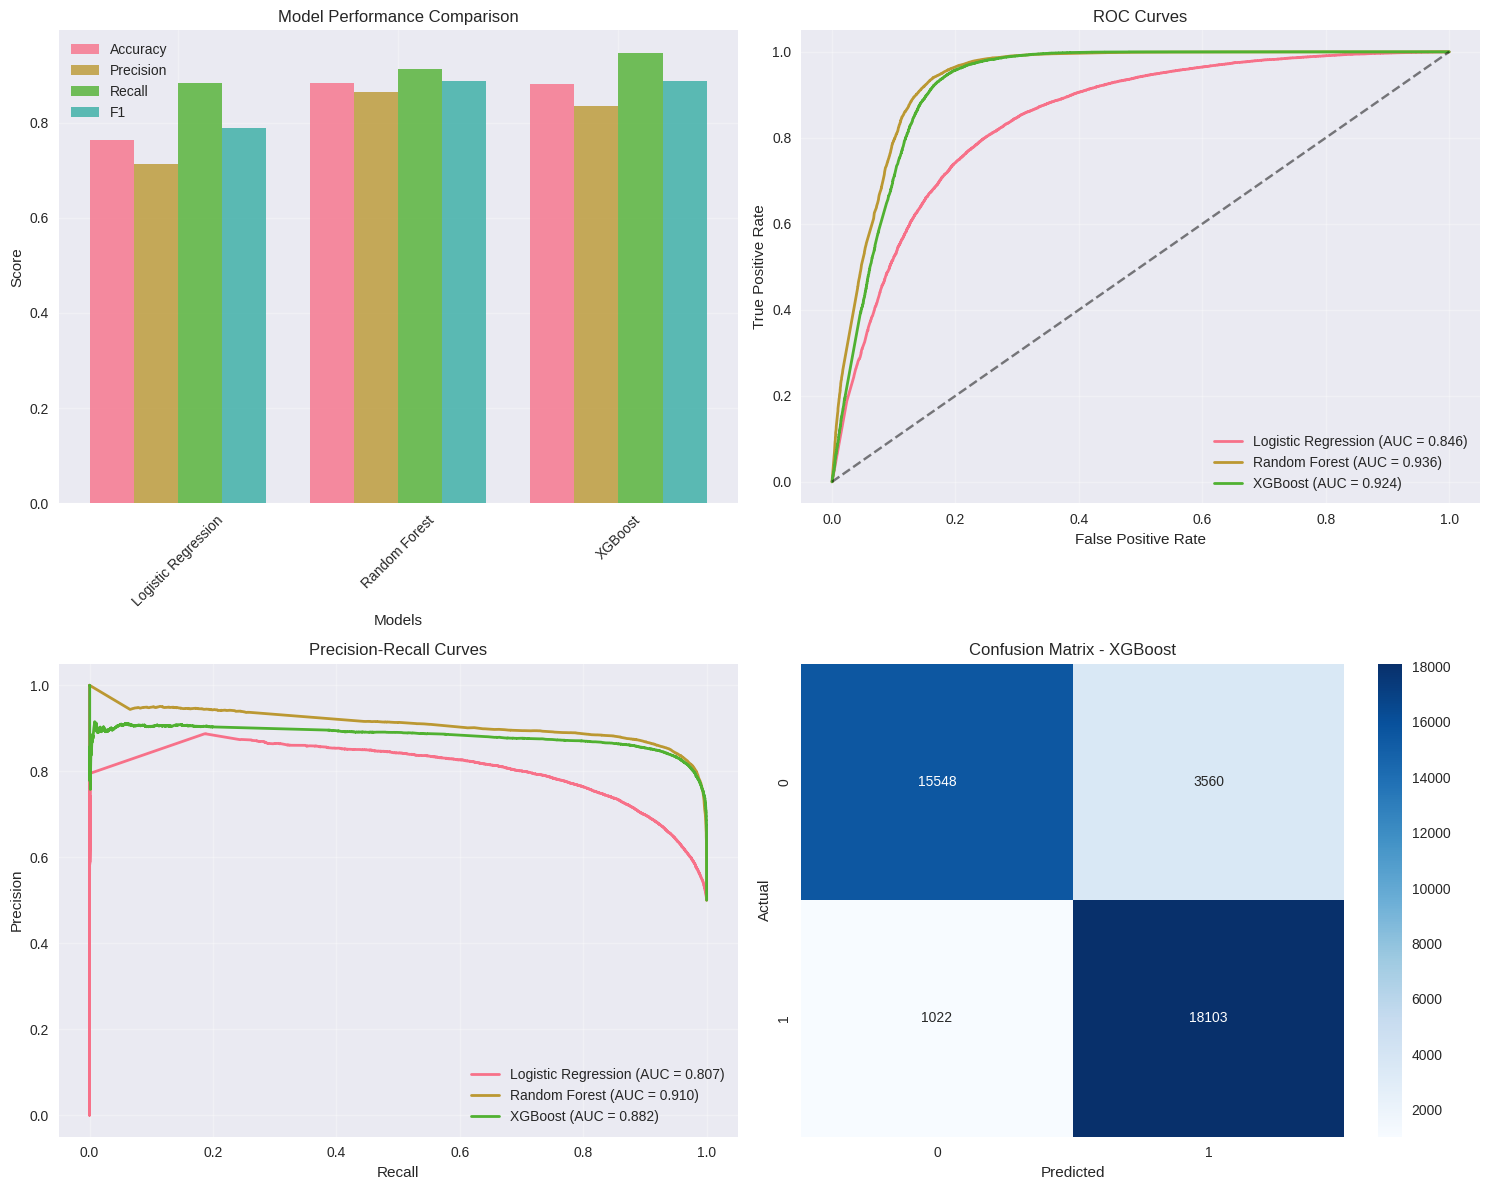

DETAILED MODEL EVALUATION RESULTS

Logistic Regression:
  Accuracy:  0.7635
  Precision: 0.7125
  Recall:    0.8836
  F1 Score:  0.7889

Random Forest:
  Accuracy:  0.8842
  Precision: 0.8636
  Recall:    0.9128
  F1 Score:  0.8875

XGBoost:
  Accuracy:  0.8802
  Precision: 0.8357
  Recall:    0.9466
  F1 Score:  0.8877
Analyzing Random Forest overfitting...
Analyzing XGBoost overfitting...


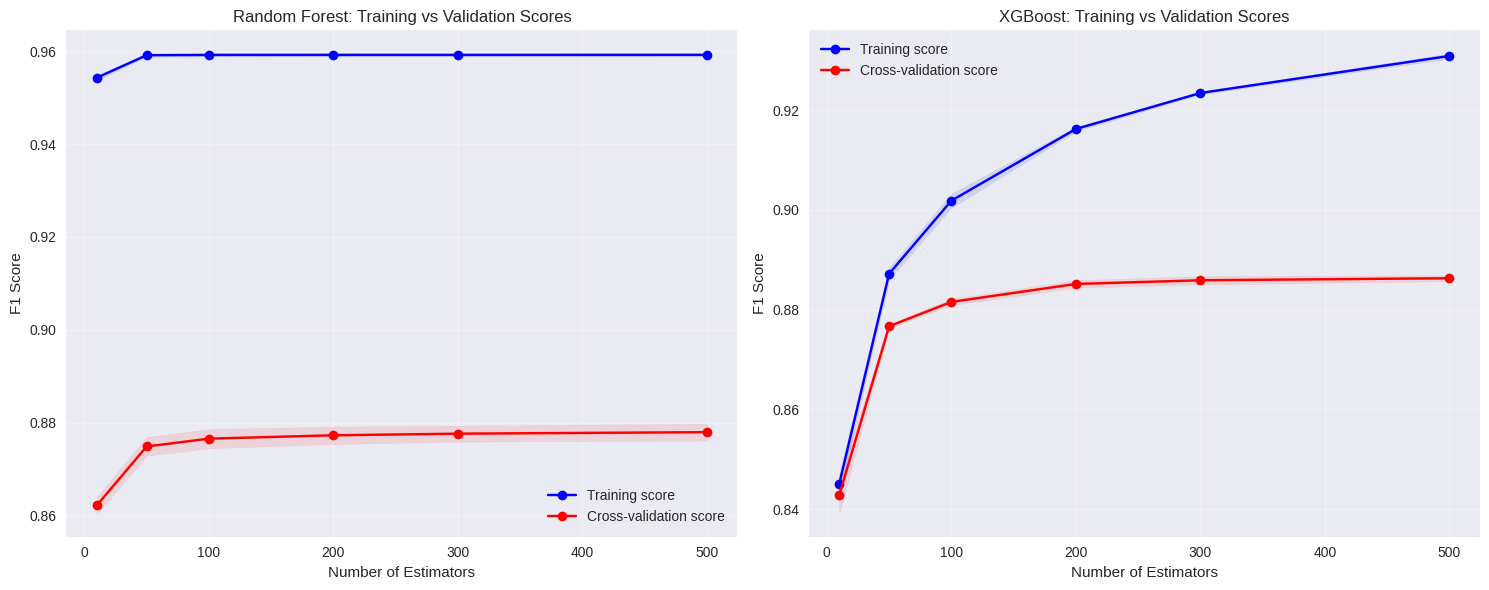

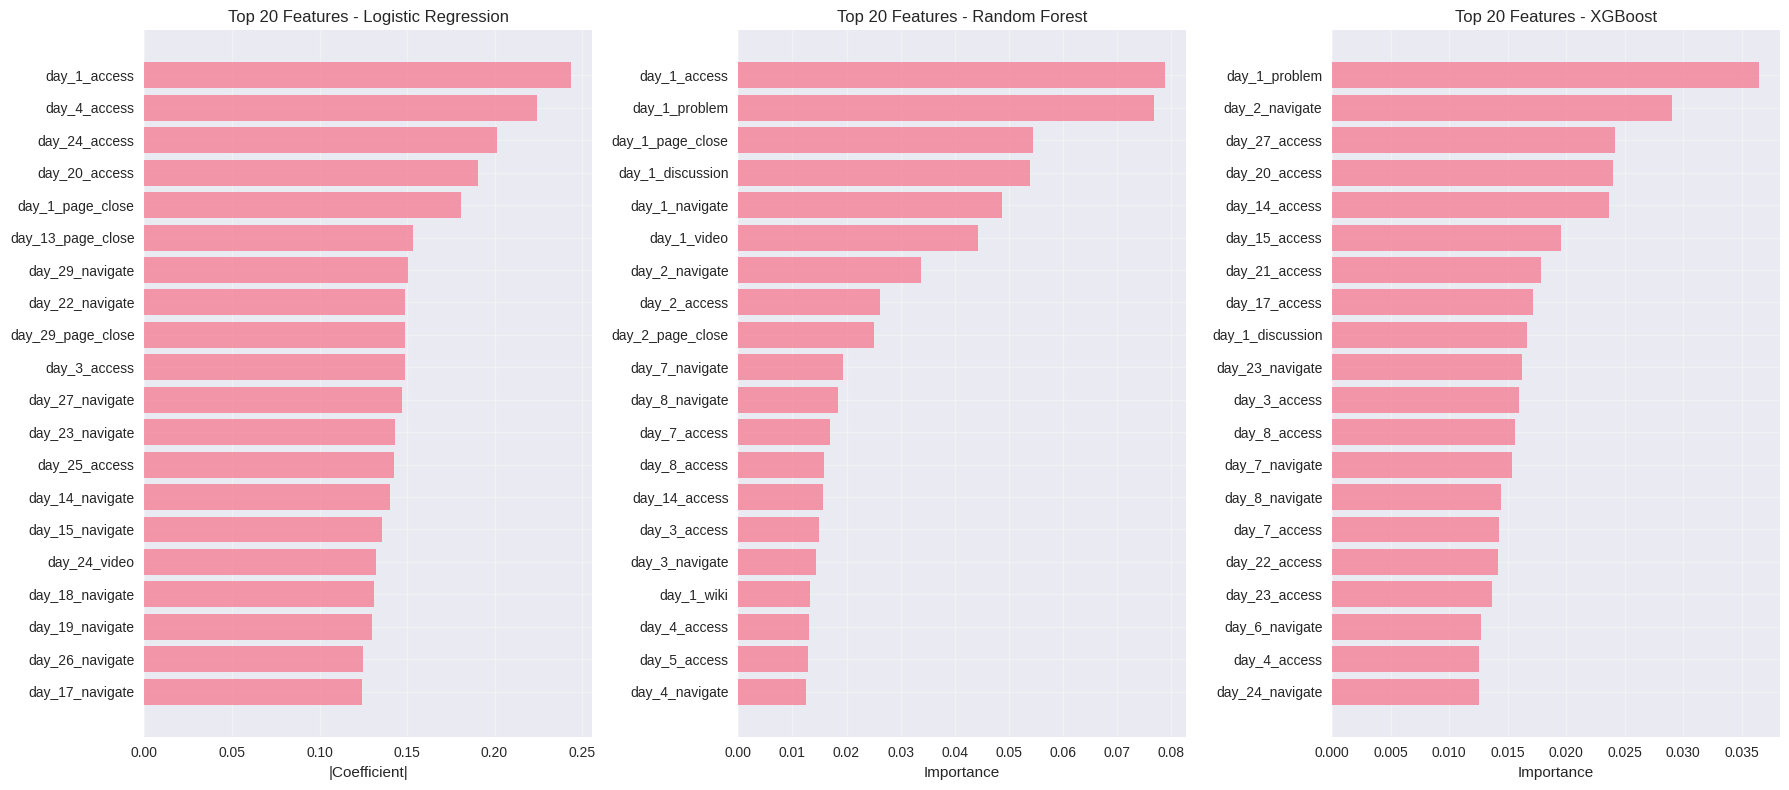

Creating SHAP explanations for Random Forest...


In [ ]:
# Install required packages
!pip install shap lime xgboost imbalanced-learn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV, validation_curve
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.metrics import roc_curve, auc, precision_recall_curve
import shap
import lime
import lime.lime_tabular
import xgboost as xgb
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings('ignore')

# Set style for better plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

def load_and_preprocess_data(file_path):
    """Load and preprocess the dataset"""
    print("Loading dataset...")
    data = pd.read_csv(file_path)
    print(f"Dataset shape: {data.shape}")
    print(f"Columns: {list(data.columns)}")

    # Check data types
    print(f"Data types:\n{data.dtypes.value_counts()}")

    # Identify non-numeric columns
    non_numeric_cols = data.select_dtypes(include=['object']).columns.tolist()
    print(f"Non-numeric columns found: {non_numeric_cols}")

    # Drop non-numeric columns that are not useful for prediction
    columns_to_drop = ['username', 'course_id', 'enrollment_id'] + non_numeric_cols
    # Remove duplicates and keep only existing columns
    existing_cols_to_drop = list(set([col for col in columns_to_drop if col in data.columns]))
    print(f"Dropping columns: {existing_cols_to_drop}")

    data_cleaned = data.drop(columns=existing_cols_to_drop)

    # Handle missing values
    data_cleaned.fillna(0, inplace=True)

    # Separate features and target variable
    if 'dropout' not in data_cleaned.columns:
        raise ValueError("Target column 'dropout' not found in the dataset")

    X = data_cleaned.drop(columns=['dropout'])
    y = data_cleaned['dropout']

    # Ensure all features are numeric
    X = X.select_dtypes(include=[np.number])

    print(f"Final features shape: {X.shape}")
    print(f"Feature columns: {list(X.columns)[:10]}...")  # Show first 10 columns
    print(f"Target distribution: {y.value_counts()}")

    # Check for any remaining non-numeric data
    if X.select_dtypes(include=['object']).shape[1] > 0:
        print("Warning: Non-numeric columns still present:")
        print(X.select_dtypes(include=['object']).columns.tolist())

    return X, y, data_cleaned

def create_balanced_dataset(X, y):
    """Create balanced dataset using SMOTE"""
    print("Applying SMOTE for class balancing...")

    # Double-check that all columns are numeric
    non_numeric_cols = X.select_dtypes(exclude=[np.number]).columns.tolist()
    if non_numeric_cols:
        print(f"Removing remaining non-numeric columns: {non_numeric_cols}")
        X = X.select_dtypes(include=[np.number])

    # Check for infinite or very large values
    if np.isinf(X.values).any():
        print("Warning: Infinite values found, replacing with 0")
        X = X.replace([np.inf, -np.inf], 0)

    # Standardize features first
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Apply SMOTE
    smote = SMOTE(sampling_strategy='auto', random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X_scaled, y)

    print(f"Original dataset shape: {X.shape}")
    print(f"Resampled dataset shape: {X_resampled.shape}")
    print(f"New target distribution: {pd.Series(y_resampled).value_counts()}")

    return X_resampled, y_resampled, scaler

def train_models(X_train, X_test, y_train, y_test):
    """Train and tune all models"""
    print("Training models...")

    # 1. Logistic Regression
    print("Training Logistic Regression...")
    lr = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
    lr.fit(X_train, y_train)

    # 2. Random Forest with RandomizedSearchCV
    print("Training Random Forest with hyperparameter tuning...")
    param_dist_rf = {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'bootstrap': [True, False]
    }

    rf = RandomForestClassifier(random_state=42)
    rf_random_search = RandomizedSearchCV(estimator=rf, param_distributions=param_dist_rf,
                                        n_iter=50, cv=3, random_state=42, n_jobs=-1)
    rf_random_search.fit(X_train, y_train)
    best_rf = rf_random_search.best_estimator_

    # 3. XGBoost with RandomizedSearchCV
    print("Training XGBoost with hyperparameter tuning...")
    param_dist_xgb = {
        'max_depth': [3, 6, 9],
        'learning_rate': [0.01, 0.1, 0.3],
        'n_estimators': [50, 100, 150],
        'subsample': [0.8, 0.9, 1.0],
        'colsample_bytree': [0.8, 0.9, 1.0]
    }

    xgb_model = xgb.XGBClassifier(random_state=42)
    xgb_random_search = RandomizedSearchCV(estimator=xgb_model, param_distributions=param_dist_xgb,
                                         n_iter=50, cv=3, random_state=42, n_jobs=-1)
    xgb_random_search.fit(X_train, y_train)
    best_xgb = xgb_random_search.best_estimator_

    models = {
        'Logistic Regression': lr,
        'Random Forest': best_rf,
        'XGBoost': best_xgb
    }

    print("Model training completed!")
    return models

def evaluate_models(models, X_test, y_test):
    """Evaluate all models and return metrics"""
    results = {}

    for name, model in models.items():
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else None

        results[name] = {
            'accuracy': accuracy_score(y_test, y_pred),
            'precision': precision_score(y_test, y_pred),
            'recall': recall_score(y_test, y_pred),
            'f1': f1_score(y_test, y_pred),
            'predictions': y_pred,
            'probabilities': y_pred_proba
        }

    return results

def plot_model_comparison(results):
    """Create comprehensive model comparison plots"""
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))

    # Metrics comparison
    metrics = ['accuracy', 'precision', 'recall', 'f1']
    models = list(results.keys())

    # Bar plot for metrics comparison
    x = np.arange(len(models))
    width = 0.2

    for i, metric in enumerate(metrics):
        values = [results[model][metric] for model in models]
        axes[0, 0].bar(x + i*width, values, width, label=metric.title(), alpha=0.8)

    axes[0, 0].set_xlabel('Models')
    axes[0, 0].set_ylabel('Score')
    axes[0, 0].set_title('Model Performance Comparison')
    axes[0, 0].set_xticks(x + width * 1.5)
    axes[0, 0].set_xticklabels(models, rotation=45)
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

    # ROC curves
    for name, result in results.items():
        if result['probabilities'] is not None:
            fpr, tpr, _ = roc_curve(y_test, result['probabilities'])
            roc_auc = auc(fpr, tpr)
            axes[0, 1].plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.3f})', linewidth=2)

    axes[0, 1].plot([0, 1], [0, 1], 'k--', alpha=0.5)
    axes[0, 1].set_xlabel('False Positive Rate')
    axes[0, 1].set_ylabel('True Positive Rate')
    axes[0, 1].set_title('ROC Curves')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)

    # Precision-Recall curves
    for name, result in results.items():
        if result['probabilities'] is not None:
            precision, recall, _ = precision_recall_curve(y_test, result['probabilities'])
            pr_auc = auc(recall, precision)
            axes[1, 0].plot(recall, precision, label=f'{name} (AUC = {pr_auc:.3f})', linewidth=2)

    axes[1, 0].set_xlabel('Recall')
    axes[1, 0].set_ylabel('Precision')
    axes[1, 0].set_title('Precision-Recall Curves')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)

    # Confusion matrices (for best model - highest F1)
    best_model = max(results.keys(), key=lambda x: results[x]['f1'])
    cm = confusion_matrix(y_test, results[best_model]['predictions'])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[1, 1])
    axes[1, 1].set_title(f'Confusion Matrix - {best_model}')
    axes[1, 1].set_xlabel('Predicted')
    axes[1, 1].set_ylabel('Actual')

    plt.tight_layout()
    plt.show()

    # Print detailed results
    print("=" * 60)
    print("DETAILED MODEL EVALUATION RESULTS")
    print("=" * 60)

    for name, result in results.items():
        print(f"\n{name}:")
        print(f"  Accuracy:  {result['accuracy']:.4f}")
        print(f"  Precision: {result['precision']:.4f}")
        print(f"  Recall:    {result['recall']:.4f}")
        print(f"  F1 Score:  {result['f1']:.4f}")

def plot_overfitting_analysis(models, X_train, y_train, feature_names):
    """Analyze and visualize overfitting for tree-based models"""
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))

    # Random Forest validation curve
    if 'Random Forest' in models:
        print("Analyzing Random Forest overfitting...")
        param_range = [10, 50, 100, 200, 300, 500]
        train_scores, val_scores = validation_curve(
            RandomForestClassifier(random_state=42), X_train, y_train,
            param_name='n_estimators', param_range=param_range,
            cv=3, scoring='f1', n_jobs=-1
        )

        train_mean = np.mean(train_scores, axis=1)
        train_std = np.std(train_scores, axis=1)
        val_mean = np.mean(val_scores, axis=1)
        val_std = np.std(val_scores, axis=1)

        axes[0].plot(param_range, train_mean, 'o-', color='blue', label='Training score')
        axes[0].fill_between(param_range, train_mean - train_std, train_mean + train_std, alpha=0.1, color='blue')
        axes[0].plot(param_range, val_mean, 'o-', color='red', label='Cross-validation score')
        axes[0].fill_between(param_range, val_mean - val_std, val_mean + val_std, alpha=0.1, color='red')

        axes[0].set_xlabel('Number of Estimators')
        axes[0].set_ylabel('F1 Score')
        axes[0].set_title('Random Forest: Training vs Validation Scores')
        axes[0].legend()
        axes[0].grid(True, alpha=0.3)

    # XGBoost validation curve
    if 'XGBoost' in models:
        print("Analyzing XGBoost overfitting...")
        param_range = [10, 50, 100, 200, 300, 500]
        train_scores, val_scores = validation_curve(
            xgb.XGBClassifier(random_state=42), X_train, y_train,
            param_name='n_estimators', param_range=param_range,
            cv=3, scoring='f1', n_jobs=-1
        )

        train_mean = np.mean(train_scores, axis=1)
        train_std = np.std(train_scores, axis=1)
        val_mean = np.mean(val_scores, axis=1)
        val_std = np.std(val_scores, axis=1)

        axes[1].plot(param_range, train_mean, 'o-', color='blue', label='Training score')
        axes[1].fill_between(param_range, train_mean - train_std, train_mean + train_std, alpha=0.1, color='blue')
        axes[1].plot(param_range, val_mean, 'o-', color='red', label='Cross-validation score')
        axes[1].fill_between(param_range, val_mean - val_std, val_mean + val_std, alpha=0.1, color='red')

        axes[1].set_xlabel('Number of Estimators')
        axes[1].set_ylabel('F1 Score')
        axes[1].set_title('XGBoost: Training vs Validation Scores')
        axes[1].legend()
        axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

def create_shap_explanations(models, X_test, X_train, feature_names):
    """Create SHAP explanations for tree-based models"""

    # SHAP for Random Forest
    if 'Random Forest' in models:
        print("Creating SHAP explanations for Random Forest...")
        explainer_rf = shap.TreeExplainer(models['Random Forest'])
        shap_values_rf = explainer_rf.shap_values(X_test[:1000])  # Use subset for faster computation

        # If binary classification, shap_values might be a list
        if isinstance(shap_values_rf, list):
            shap_values_rf = shap_values_rf[1]  # Use positive class

        # Summary plot
        plt.figure(figsize=(12, 8))
        shap.summary_plot(shap_values_rf, X_test[:1000], feature_names=feature_names, show=False)
        plt.title('SHAP Summary Plot - Random Forest')
        plt.tight_layout()
        plt.show()

        # Feature importance plot
        plt.figure(figsize=(12, 8))
        shap.summary_plot(shap_values_rf, X_test[:1000], feature_names=feature_names, plot_type="bar", show=False)
        plt.title('SHAP Feature Importance - Random Forest')
        plt.tight_layout()
        plt.show()

    # SHAP for XGBoost
    if 'XGBoost' in models:
        print("Creating SHAP explanations for XGBoost...")
        explainer_xgb = shap.TreeExplainer(models['XGBoost'])
        shap_values_xgb = explainer_xgb.shap_values(X_test[:1000])

        # Summary plot
        plt.figure(figsize=(12, 8))
        shap.summary_plot(shap_values_xgb, X_test[:1000], feature_names=feature_names, show=False)
        plt.title('SHAP Summary Plot - XGBoost')
        plt.tight_layout()
        plt.show()

        # Feature importance plot
        plt.figure(figsize=(12, 8))
        shap.summary_plot(shap_values_xgb, X_test[:1000], feature_names=feature_names, plot_type="bar", show=False)
        plt.title('SHAP Feature Importance - XGBoost')
        plt.tight_layout()
        plt.show()

def create_lime_explanations(models, X_train, X_test, y_train, feature_names):
    """Create LIME explanations"""
    print("Creating LIME explanations...")

    # Create LIME explainer
    explainer_lime = lime.lime_tabular.LimeTabularExplainer(
        training_data=X_train,
        training_labels=y_train,
        mode="classification",
        feature_names=feature_names,
        class_names=["No Dropout", "Dropout"],
        verbose=True,
        random_state=42
    )

    # Explain instances for each model
    fig, axes = plt.subplots(1, len(models), figsize=(5*len(models), 6))
    if len(models) == 1:
        axes = [axes]

    for idx, (name, model) in enumerate(models.items()):
        # Pick a random instance
        instance_idx = np.random.randint(0, len(X_test))
        instance = X_test[instance_idx]

        # Create explanation
        explanation = explainer_lime.explain_instance(
            instance,
            model.predict_proba if hasattr(model, 'predict_proba') else model.decision_function,
            num_features=10
        )

        # Extract feature importance
        exp_list = explanation.as_list()
        features = [item[0] for item in exp_list]
        importances = [item[1] for item in exp_list]

        # Plot
        colors = ['red' if x < 0 else 'green' for x in importances]
        axes[idx].barh(features, importances, color=colors, alpha=0.7)
        axes[idx].set_title(f'LIME Explanation - {name}')
        axes[idx].set_xlabel('Feature Importance')
        axes[idx].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

def plot_feature_importance_comparison(models, feature_names):
    """Compare feature importance across models"""
    fig, axes = plt.subplots(1, len(models), figsize=(6*len(models), 8))
    if len(models) == 1:
        axes = [axes]

    for idx, (name, model) in enumerate(models.items()):
        if hasattr(model, 'feature_importances_'):
            importance = model.feature_importances_
            # Get top 20 features
            top_indices = np.argsort(importance)[-20:]
            top_features = [feature_names[i] for i in top_indices]
            top_importance = importance[top_indices]

            axes[idx].barh(top_features, top_importance, alpha=0.7)
            axes[idx].set_title(f'Top 20 Features - {name}')
            axes[idx].set_xlabel('Importance')
            axes[idx].grid(True, alpha=0.3)
        elif hasattr(model, 'coef_'):
            # For logistic regression
            importance = np.abs(model.coef_[0])
            top_indices = np.argsort(importance)[-20:]
            top_features = [feature_names[i] for i in top_indices]
            top_importance = importance[top_indices]

            axes[idx].barh(top_features, top_importance, alpha=0.7)
            axes[idx].set_title(f'Top 20 Features - {name}')
            axes[idx].set_xlabel('|Coefficient|')
            axes[idx].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

# Main execution
if __name__ == "__main__":
    # Load and preprocess data
    file_path = 'model1_210_features.csv'  # Update this path as needed
    try:
        X, y, data = load_and_preprocess_data(file_path)
        print("Data loading successful!")

        # Additional data validation
        print(f"\nData validation:")
        print(f"X shape: {X.shape}")
        print(f"y shape: {y.shape}")
        print(f"X data types: {X.dtypes.nunique()} unique types")
        print(f"Any missing values in X: {X.isnull().sum().sum()}")
        print(f"Any missing values in y: {y.isnull().sum()}")

        # Check for any non-finite values
        print(f"Any infinite values in X: {np.isinf(X.values).sum()}")
        print(f"Any NaN values in X after fillna: {np.isnan(X.values).sum()}")

    except Exception as e:
        print(f"Error loading data: {e}")
        raise

    # Create balanced dataset
    try:
        X_resampled, y_resampled, scaler = create_balanced_dataset(X, y)
        print("Data balancing successful!")
    except Exception as e:
        print(f"Error in data balancing: {e}")
        raise

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X_resampled, y_resampled, test_size=0.2, random_state=42
    )

    # Train models
    models = train_models(X_train, X_test, y_train, y_test)

    # Evaluate models
    results = evaluate_models(models, X_test, y_test)

    # Create visualizations
    print("\n" + "="*60)
    print("CREATING VISUALIZATIONS")
    print("="*60)

    # 1. Model comparison
    plot_model_comparison(results)

    # 2. Overfitting analysis
    plot_overfitting_analysis(models, X_train, y_train, X.columns)

    # 3. Feature importance comparison
    plot_feature_importance_comparison(models, X.columns)

    # 4. SHAP explanations
    create_shap_explanations(models, X_test, X_train, X.columns)

    # 5. LIME explanations
    create_lime_explanations(models, X_train, X_test, y_train, X.columns)

    print("\n" + "="*60)
    print("ANALYSIS COMPLETE!")
    print("="*60)